In [1]:
%matplotlib inline

# An LSTM for Part-of-Speech Tagging
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Load Data

In [3]:
import csv
Dataset = []
with open('Data/Parsed_simpletag.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
   
    data = []
    for row in csv_reader:
        
        if len(row) == 0:
            Dataset.append(data)
            data = []
        else:
            tag = [row[0], row[1], row[2]]
            data.append(tag)

## Prepare data!

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [41]:
use_lemms = 1

data = []
for sentence in Dataset:
    sentence_data = []
    words = []
    tags = []
    for word in sentence:
        words.append(word[use_lemms])
        tags.append(word[2])
    
    sentence_data.append(words)
    sentence_data.append(tags)
    
    sentence_data = tuple(sentence_data)
    data.append(sentence_data)
    
print('num of sentences:', len(data))

num of sentences: 87782


In [7]:
data[100:105]

[(['нет', '.'], ['PART', 'PUNCT']),
 (['один', 'только', 'кусочек', 'холодный', 'остаться', '.'],
  ['ANUM', 'PART', 'S', 'A', 'V', 'PUNCT']),
 (['В', '..'], ['INIT', 'PUNCT']),
 (['давайте', 'погреть', '.'], ['PART', 'V', 'PUNCT']),
 (['Б', '..'], ['INIT', 'PUNCT'])]

## Make w2v!!!

In [8]:
import gensim
from pymystem3 import Mystem
#import pymorphy2
from ufal.udpipe import Model, Pipeline

word_vectors = gensim.models.KeyedVectors.load_word2vec_format("/home/r/Documents/data_w2v/tenth.norm-sz500-w7-cb0-it5-min5.w2v", 
                                                               binary=True, unicode_errors='ignore')

print(word_vectors.vectors.shape)

(2641862, 500)


In [9]:
path = 'udpipes/'
modelfile1 = 'russian-syntagrus-ud-2.3-181115.udpipe'
modelfile2 = 'russian-gsd-ud-2.3-181115.udpipe'
modelfile3 = 'russian-taiga-ud-2.3-181115.udpipe'

model1 = Model.load(path + modelfile1)
model2 = Model.load(path + modelfile2)
model3 = Model.load(path + modelfile3)

In [10]:
def tag_ufal(word, model):
    
    pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    processed = pipeline.process(word)
    output = [l for l in processed.split('\n') if not l.startswith('#')]
    tagged = ['_'.join(w.split('\t')[2:4]) for w in output if w]
    tagged = [w.split('\t')[2] for w in output if w]

    if len(tagged) > 1:
        pass
        #print('MANY tags!')
        #print(word, tagged)
    return tagged[0]

In [71]:
word_vectors["vector"]

array([-0.18125933,  0.04451561,  0.04566395, -0.08743411,  0.06082746,
        0.3114289 , -0.27108607,  0.12590593,  0.27222472,  0.4354773 ,
       -0.14616688, -0.1757782 ,  0.0132714 , -0.15076365,  0.07179581,
       -0.16493756, -0.03184904, -0.39687994,  0.02206128, -0.0151894 ,
       -0.08458586, -0.12455434,  0.08239872,  0.15433611,  0.36637557,
       -0.14813724, -0.00548346,  0.0207062 , -0.11735547, -0.07771657,
       -0.23354442, -0.05254282, -0.01529887, -0.00365412,  0.05576355,
        0.10970679, -0.06045992,  0.2756294 ,  0.35827807,  0.19157635,
       -0.15099981, -0.04767626,  0.11978843, -0.1600945 , -0.21727917,
       -0.10526314,  0.14590985, -0.3157325 , -0.00958069,  0.1108558 ,
        0.12626551,  0.03842518,  0.0819481 , -0.00221886,  0.2589593 ,
       -0.07106131,  0.01050402, -0.03745199,  0.04808694,  0.09731693,
       -0.00947738, -0.11228902,  0.40869322, -0.3294705 ,  0.22165246,
        0.02771976, -0.16267037,  0.13831954, -0.06457084,  0.19

### extract vectors!

In [15]:
repair = {
    '0': 'ноль',
    '1': 'один',
    '2': 'два',
    '3': 'три',
    '4': 'четыре',
    '5': 'пять',
    '6': 'шесть',
    '7': 'семь',
    '8': 'восемь',
    '9': 'девять',
    '10': 'десять',
    ':': '-',
    ';': ',',
    ':"': '-',
    
}

In [42]:
w2v_data = []

faild_words = []
faild_tags = []

for i, sentence in enumerate(data):
    
    if i % 5000 == 0:
        print('iter =', i)
    #print(sentence)
    
    flag = True
    
    new_sentence = []
    for i, word in enumerate(sentence[0]):
        
        word = word.lower()
        
        # repair some words!
        if word in list(repair.keys()):
            word = repair[word]
        if word.count('-') == 1 and len(word) != 1:
            ind = word.index('-')
            word = word[:ind] + word[ind + 1:]
            
        for letter in word:
            if ord(letter) >= 97 and ord(letter) <= 122 or \
            ord(letter) >= 65 and ord(letter) <= 90:
                word = 'vector'
        
        # try-excepts for
        try:
            word_vectors[word]
            new_sentence.append(word)
            
        except KeyError:
            try:
                tag = tag_ufal(word, model1)
                word_vectors[tag]
                new_sentence.append(tag)
            except KeyError:
                try:
                    tag = tag_ufal(word, model2)
                    word_vectors[tag]
                    new_sentence.append(tag)
                except KeyError:
                    try:
                        tag = tag_ufal(word, model3)
                        word_vectors[tag]
                        new_sentence.append(tag)
                    except KeyError:
                        faild_words.append(word)
                        faild_tags.append(sentence[1][i])
                        flag = False
    
    if flag == True:
        w2v_data.append((new_sentence, sentence[1]))


iter = 0
iter = 5000
iter = 10000
iter = 15000
iter = 20000
iter = 25000
iter = 30000
iter = 35000
iter = 40000
iter = 45000
iter = 50000
iter = 55000
iter = 60000
iter = 65000
iter = 70000
iter = 75000
iter = 80000
iter = 85000


In [43]:
data = w2v_data
len(data)

77098

## REAPIR!

In [21]:
# create dicts!

failw = {}
for fail in faild_words:
    try:
        failw[fail] += 1
    except:
        failw[fail] = 1     
        
failt = {}
for fail in faild_tags:
    try:
        failt[fail] += 1
    except:
        failt[fail] = 1

In [22]:
sorted_x = sorted(failw.items(), key=lambda kv: kv[1], reverse=True)
sorted_x

[('«', 528),
 ('»', 235),
 ('20', 225),
 ('12', 214),
 ('15', 206),
 ('2002', 202),
 ('2003', 184),
 ('30', 179),
 ('11', 177),
 ('50', 154),
 ('».', 153),
 ('2001', 152),
 ('14', 150),
 ('25', 143),
 ('40', 138),
 ('18', 134),
 ('16', 130),
 ('|', 129),
 ('13', 128),
 ('2000', 124),
 ('17', 118),
 ('22', 111),
 ('19', 110),
 ('100', 108),
 ('»,', 99),
 ('21', 95),
 (':--', 91),
 ('24', 90),
 ('=', 90),
 ('60', 87),
 ('00', 84),
 ('1995', 75),
 ('70', 74),
 ('1998', 69),
 ('27', 68),
 ('23', 68),
 ('28', 67),
 ('1999', 63),
 ('45', 61),
 ('2004', 61),
 ('элуцидарий', 59),
 ('35', 58),
 ('26', 58),
 ('500', 57),
 ('29', 57),
 ('33', 52),
 ('90', 52),
 ('1996', 51),
 ('36', 50),
 ('39', 49),
 ('300', 48),
 ('\x95', 47),
 ('80', 45),
 ('150', 44),
 ('1997', 43),
 ('01', 43),
 ('заработный', 42),
 ('32', 41),
 ('37', 41),
 ('31', 41),
 ('1994', 41),
 ('1991', 39),
 ('200', 38),
 ('яэу', 38),
 ('30й', 37),
 ('38', 37),
 ('48', 36),
 ('дебоширин', 36),
 ('*', 36),
 ('34', 34),
 ('пелипейко',

In [23]:
sorted_y = sorted(failt.items(), key=lambda kv: kv[1], reverse=True)
sorted_y

[('NUM', 8628),
 ('S', 3261),
 ('A', 2169),
 ('PUNCT', 1707),
 ('ANUM', 556),
 ('V', 305),
 ('ADV', 94),
 ('NONLEX', 80),
 ('PART', 27),
 ('INTJ', 19),
 ('ADVPRO', 7),
 ('APRO', 6),
 ('PRAEDIC', 1),
 ('PARENTH', 1),
 ('SPRO', 1)]

In [46]:
# create dicts!

tag_count = {}
for sent, tags in data:

    for tag in tags:
        
        try:
            tag_count[tag] += 1
        except:
            tag_count[tag] = 1       


In [47]:
tag_count

{'PUNCT': 203016,
 'NUM': 12909,
 'V': 121230,
 'S': 214176,
 'PARENTH': 4153,
 'PART': 36821,
 'CONJ': 60130,
 'APRO': 37938,
 'SPRO': 62164,
 'A': 65753,
 'ADVPRO': 18958,
 'ADV': 32111,
 'PR': 75795,
 'PRAEDIC': 6792,
 'INTJ': 884,
 'ANUM': 2772,
 'INIT': 2255,
 'NONLEX': 4467,
 'PRAEDICPRO': 80}

### Train_test split

In [44]:
# create dicts!

word_to_ix = {}
tag_to_ix = {}
for sent, tags in data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)        
print(len(word_to_ix), len(tag_to_ix))

37045 19


In [48]:
from sklearn.model_selection import train_test_split
num_of_test = 0.2

train_data, test_data = train_test_split(data, test_size = num_of_test, random_state = 12345)
print(len(train_data), len(test_data))

61678 15420


# Train the model:



In [49]:
class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim1, hidden_dim2, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        #self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim1.
        self.lstm = nn.LSTM(500, hidden_dim1, bidirectional=True)

        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim2 * 2, tagset_size)
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):

        return (torch.zeros(2, 1, self.hidden_dim1),
                torch.zeros(2, 1, self.hidden_dim1))

    def init_hidden2(self):

        return (torch.zeros(2, 1, self.hidden_dim2),
                torch.zeros(2, 1, self.hidden_dim2))

    def forward(self, sentence):
        
        lstm_out, self.hidden = self.lstm(
            sentence, self.hidden1)

        lstm_out2, self.hidden = self.lstm2(
            lstm_out.view(len(sentence), 1, -1), self.hidden2)

        tag_space = self.hidden2tag(lstm_out2.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Funcs

In [50]:
def train(sentence, tag):
    model.zero_grad()

    sentence_in = torch.Tensor(word_vectors[sentence])
    sentence_in = sentence_in.view(len(sentence), 1, -1)
    
    targets = prepare_sequence(tag, tag_to_ix)

    # forward pass
    tag_scores = model(sentence_in)

    # loss and backward
    loss = loss_function(tag_scores, targets)
    
    loss.backward()
    
    loss.detach_()
    optimizer.step()
        
    return tag_scores, loss

In [51]:
from sklearn.metrics import accuracy_score

def evaluate(num_iter = 100):
    with torch.no_grad():
        
        main_score = 0
        for i in range(num_iter):
            rng = np.random.randint(len(test_data))
            
            sentence = test_data[rng][0]
            
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)
            
            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[rng][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / num_iter

In [52]:
def total_evaluate():
    with torch.no_grad():
        
        main_score = 0
        for i in range(len(test_data)):
            sentence = test_data[i][0]
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / len(test_data)

In [53]:
def train_rng():
    
    rng = np.random.randint(len(train_data))
    
    sentence = train_data[rng][0]
    tag = train_data[rng][1]
    
    return sentence, tag

In [54]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## GONNA TRAIN!

In [55]:
HIDDEN_DIM = 300
HIDDEN_DIM2 = 300

model = LSTMTagger(HIDDEN_DIM, HIDDEN_DIM2, len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [56]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 20000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 1% (0m 26s) loss: 2.1193 accuracy on test: 0.3116
600 3% (0m 53s) loss: 2.0118 accuracy on test: 0.3295
900 4% (1m 19s) loss: 1.7515 accuracy on test: 0.5235
1200 6% (1m 45s) loss: 1.5197 accuracy on test: 0.5494
1500 7% (2m 10s) loss: 1.1873 accuracy on test: 0.6494
1800 9% (2m 35s) loss: 0.8410 accuracy on test: 0.7386
2100 10% (3m 1s) loss: 0.6839 accuracy on test: 0.7689
2400 12% (3m 27s) loss: 0.6683 accuracy on test: 0.8479
2700 13% (3m 54s) loss: 0.4990 accuracy on test: 0.8626
3000 15% (4m 22s) loss: 0.4131 accuracy on test: 0.8701
3300 16% (4m 47s) loss: 0.4322 accuracy on test: 0.8657
3600 18% (5m 13s) loss: 0.3317 accuracy on test: 0.8578
3900 19% (5m 36s) loss: 0.3083 accuracy on test: 0.8670
4200 21% (5m 58s) loss: 0.3561 accuracy on test: 0.8913
4500 22% (6m 22s) loss: 0.3285 accuracy on test: 0.9220
4800 24% (6m 46s) loss: 0.1934 accuracy on test: 0.8953
5100 25% (7m 11s) loss: 0.2371 accuracy on test: 0.9061
5400 27% (7m 39s) loss: 0.3053 accuracy on test: 0.9515
57

0.9724472183483904


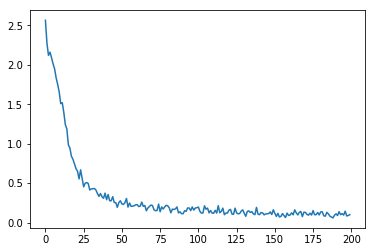

In [57]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [58]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 15000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 2% (0m 24s) loss: 0.0641 accuracy on test: 0.9679
600 4% (0m 47s) loss: 0.0756 accuracy on test: 0.9678
900 6% (1m 13s) loss: 0.0733 accuracy on test: 0.9769
1200 8% (1m 40s) loss: 0.1192 accuracy on test: 0.9761
1500 10% (2m 7s) loss: 0.0816 accuracy on test: 0.9783
1800 12% (2m 33s) loss: 0.0909 accuracy on test: 0.9677
2100 14% (3m 0s) loss: 0.1047 accuracy on test: 0.9761
2400 16% (3m 28s) loss: 0.0853 accuracy on test: 0.9723
2700 18% (3m 57s) loss: 0.0811 accuracy on test: 0.9746
3000 20% (4m 26s) loss: 0.0524 accuracy on test: 0.9799
3300 22% (4m 55s) loss: 0.0773 accuracy on test: 0.9738
3600 24% (5m 25s) loss: 0.0880 accuracy on test: 0.9806
3900 26% (5m 54s) loss: 0.0847 accuracy on test: 0.9741
4200 28% (6m 22s) loss: 0.0999 accuracy on test: 0.9809
4500 30% (6m 52s) loss: 0.0727 accuracy on test: 0.9772
4800 32% (7m 21s) loss: 0.0647 accuracy on test: 0.9649
5100 34% (7m 50s) loss: 0.0505 accuracy on test: 0.9776
5400 36% (8m 18s) loss: 0.1233 accuracy on test: 0.9783
5

0.9773405541590077


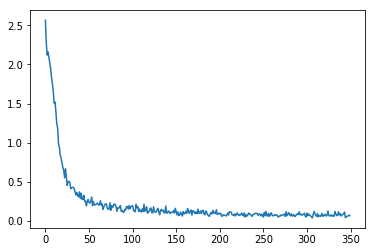

In [59]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [60]:
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 10000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 3% (0m 27s) loss: 0.0466 accuracy on test: 0.9868
600 6% (0m 56s) loss: 0.0684 accuracy on test: 0.9748
900 9% (1m 28s) loss: 0.0851 accuracy on test: 0.9755
1200 12% (1m 57s) loss: 0.0947 accuracy on test: 0.9830
1500 15% (2m 25s) loss: 0.0990 accuracy on test: 0.9767
1800 18% (2m 56s) loss: 0.0993 accuracy on test: 0.9811
2100 21% (3m 25s) loss: 0.1585 accuracy on test: 0.9742
2400 24% (3m 54s) loss: 0.0810 accuracy on test: 0.9708
2700 27% (4m 23s) loss: 0.0767 accuracy on test: 0.9837
3000 30% (4m 50s) loss: 0.0556 accuracy on test: 0.9658
3300 33% (5m 19s) loss: 0.0669 accuracy on test: 0.9794
3600 36% (5m 50s) loss: 0.0634 accuracy on test: 0.9731
3900 39% (6m 15s) loss: 0.0529 accuracy on test: 0.9737
4200 42% (6m 41s) loss: 0.0487 accuracy on test: 0.9796
4500 45% (7m 7s) loss: 0.0586 accuracy on test: 0.9850
4800 48% (7m 32s) loss: 0.0562 accuracy on test: 0.9768
5100 51% (8m 0s) loss: 0.0885 accuracy on test: 0.9732
5400 54% (8m 25s) loss: 0.0830 accuracy on test: 0.9762


0.9776984914799725


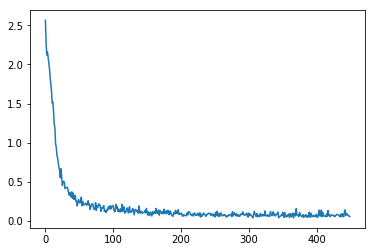

In [61]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

## Save and load models

In [65]:
path = 'Data/Models/pos-tag'

torch.save(model.state_dict(), path)

In [27]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model.load_state_dict(torch.load(path))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(50806, 64)
  (lstm): LSTM(64, 128)
  (hidden2tag): Linear(in_features=128, out_features=19, bias=True)
)

## confusion matrix

In [62]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

n_confusion = 1000
y_train = []
y_test = []
with torch.no_grad():
    for i in range(len(test_data)):
        try:
            
            sentence = test_data[i][0]
            
            sentence_in = np.empty((len(sentence), 500))
            for j in range(len(sentence)):
                sentence_in[j] = word_vectors[sentence[j]]

            sentence_in = torch.Tensor(sentence_in)
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            for j in range(len(true_values)):
                confusion[true_values[j]][topi[j]] += 1 # инк ячейку
                y_train.append(topi[j].item())
                y_test.append(true_values[j].item())
        except RuntimeError:
            pass
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

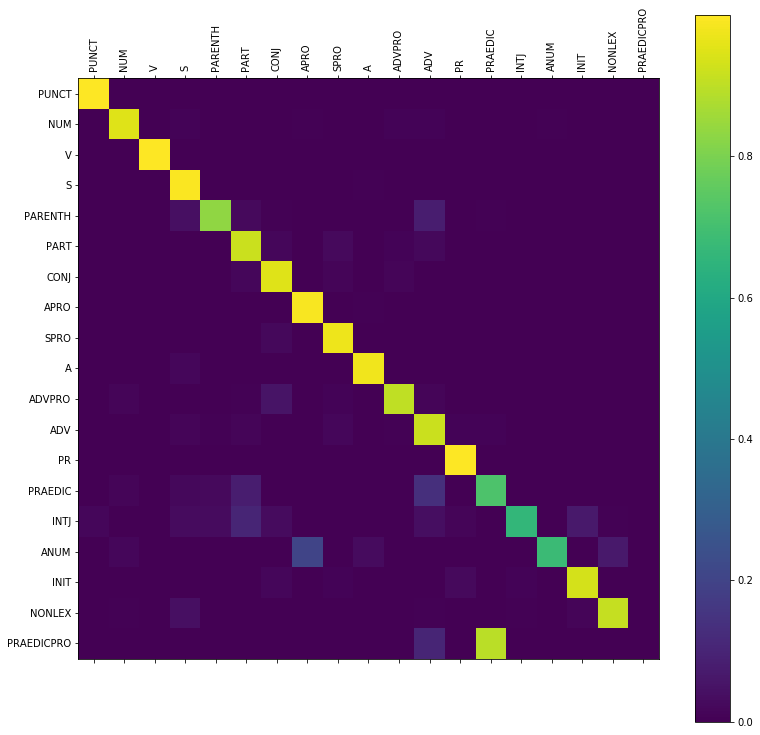

In [63]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [64]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

a = classification_report(y_test, y_train, target_names = [str(K) for K in list(tag_to_ix.keys())])

print(a)

              precision    recall  f1-score   support

       PUNCT       1.00      1.00      1.00     40332
         NUM       0.96      0.95      0.95      2618
           V       1.00      1.00      1.00     24509
           S       0.99      0.99      0.99     42353
     PARENTH       0.86      0.83      0.85       846
        PART       0.93      0.92      0.93      7477
        CONJ       0.95      0.95      0.95     12326
        APRO       0.98      0.99      0.98      7632
        SPRO       0.96      0.97      0.96     12505
           A       0.98      0.98      0.98     13061
      ADVPRO       0.92      0.90      0.91      3821
         ADV       0.90      0.92      0.91      6299
          PR       0.99      1.00      0.99     15063
     PRAEDIC       0.89      0.72      0.80      1429
        INTJ       0.82      0.66      0.73       162
        ANUM       0.92      0.68      0.78       555
        INIT       0.89      0.93      0.91       444
      NONLEX       0.90    

/home/r/anaconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
